In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [2]:
stock = 'AMD'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [3]:
globals()[stock] = yf.download(stock, start, end)
df_amd = globals()[stock]

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning

In [4]:
df_amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,81.970001,82.000000,78.459999,78.550003,78.550003,66323300
2021-05-04,77.949997,78.669998,77.040001,78.610001,78.610001,59194300
2021-05-05,79.050003,79.300003,77.360001,77.830002,77.830002,42310200
2021-05-06,77.629997,78.059998,76.470001,77.889999,77.889999,38661300
2021-05-07,78.750000,79.570000,78.220001,78.809998,78.809998,36954200


In [5]:
df_amd.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-25,149.149994,155.139999,146.750000,153.759995,153.759995,41471400
2024-04-26,154.240005,158.630005,153.429993,157.399994,157.399994,42510700
2024-04-29,159.080002,160.770004,156.259995,160.199997,160.199997,43478200
2024-04-30,160.630005,162.289993,158.350006,158.380005,158.380005,60742800
2024-05-01,148.110001,151.369995,142.139999,144.270004,144.270004,89234400


In [6]:
df_amd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2021-05-03 to 2024-05-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       755 non-null    float64
 1   High       755 non-null    float64
 2   Low        755 non-null    float64
 3   Close      755 non-null    float64
 4   Adj Close  755 non-null    float64
 5   Volume     755 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


In [7]:
df_amd.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No Cleaning is required.

## Data Analysis

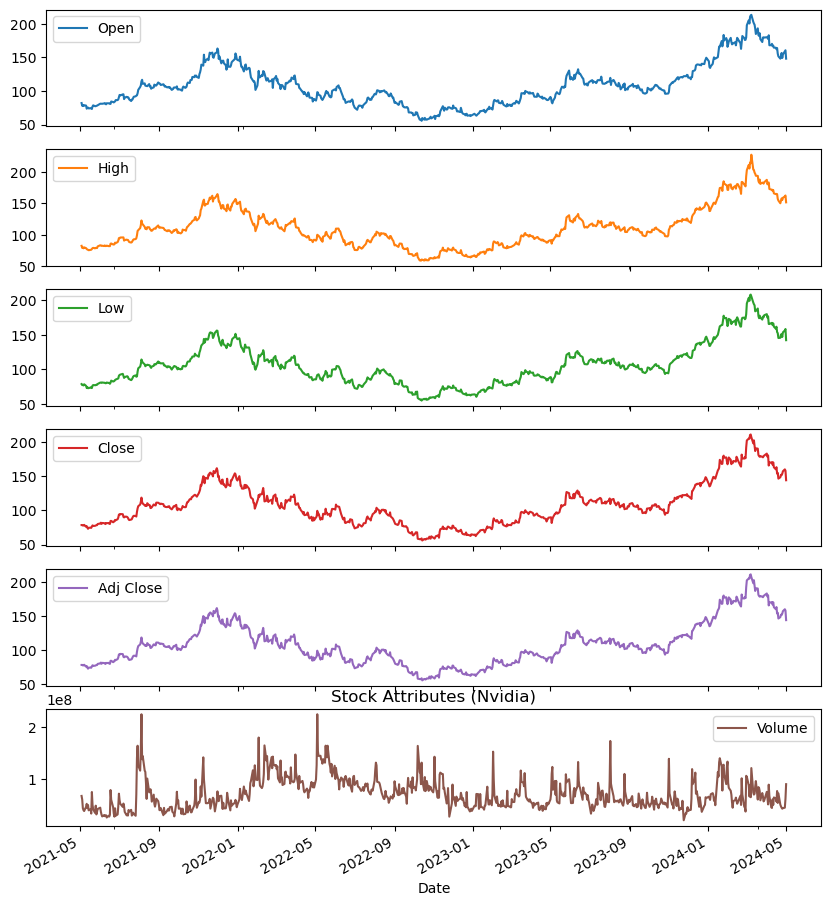

In [8]:
df_amd.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [9]:
fig = px.line(df_amd, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Judging the Closing price, AMD has been experiencing a volatile rise and drop in its price. The most recent drop can be explained with AMD's struggle to impress Wall Street with its earnings season, investors were not impressed even amid the rise in AI demand. Leading to a near 9% drop in stock price and affecting other company stocks such as Nvidia with a 3% stock drop. This may be a good opportunity to take in the semiconductor market to start investing into AMD.

In [10]:
fig = px.line(df_amd, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

### Calculation of Moving Average 

In [12]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()

Text(0.5, 1.0, 'AMD')

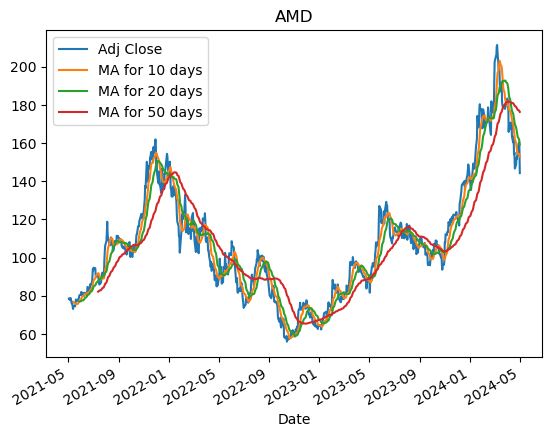

In [15]:
df_amd[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("AMD Moving Averages")

Based on the graph, the best moving average is 10 days and 20 days because they still capture trends in the data before getting too diluted.

Text(0.5, 1.0, 'AMD Daily Return')

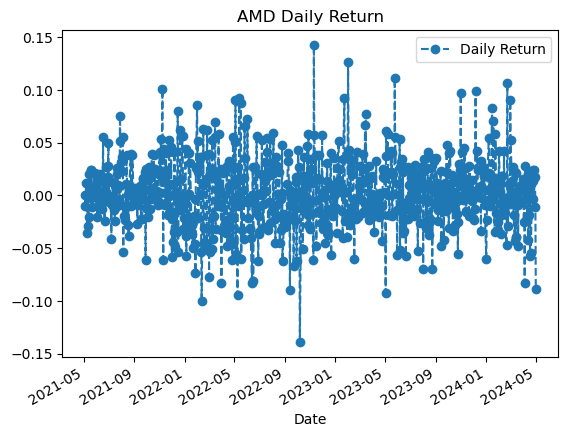

In [16]:
df_amd['Daily Return'] = df_amd['Adj Close'].pct_change()

df_amd['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title("AMD Daily Return")

Will use a histogram to get a better view

Text(0.5, 1.0, 'AMD Daily Return')

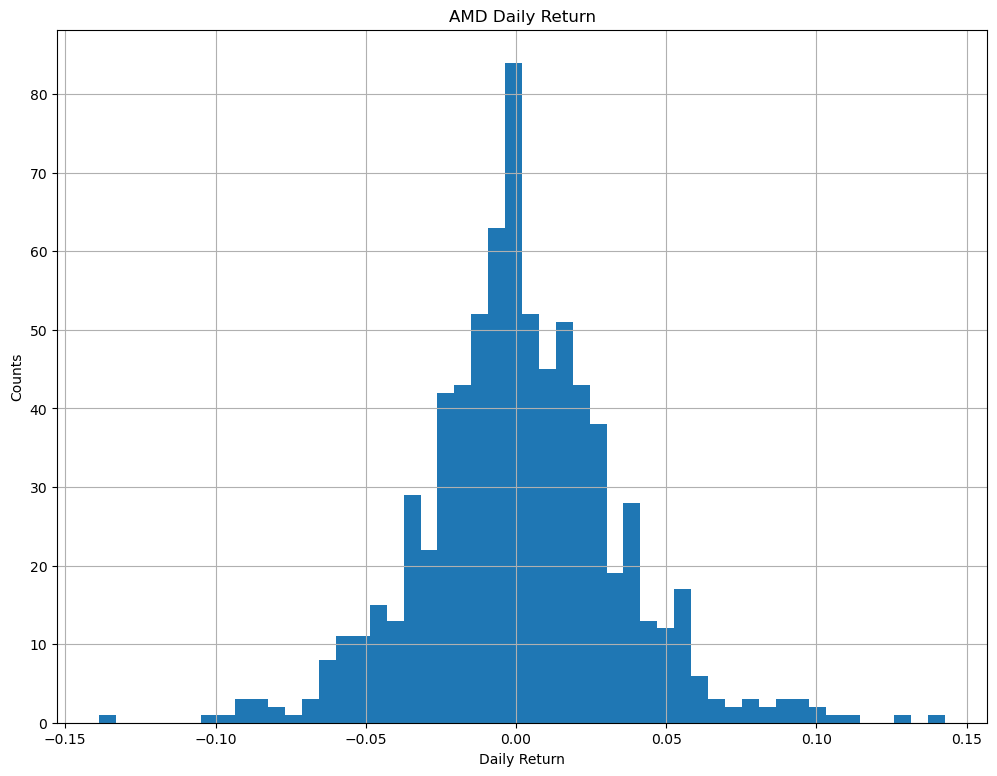

In [17]:
plt.figure(figsize=(12,9))

df_amd['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('AMD Daily Return')

### Candlestick Chart Data

In [11]:
# AMD Candlestick Chart
# Further detailed chart evaluating noticeable drops and rises in data.

fig = go.Figure(data=[go.Candlestick(x=df_amd.index, open=df_amd['Open'], high=df_amd['High'], low=df_amd['Low'], close=df_amd['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

What is the risk for investing into the stock?

In [22]:
closing_df = pdr.get_data_yahoo(stock, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  1 of 1 completed


Text(50, 50, 'AMD')

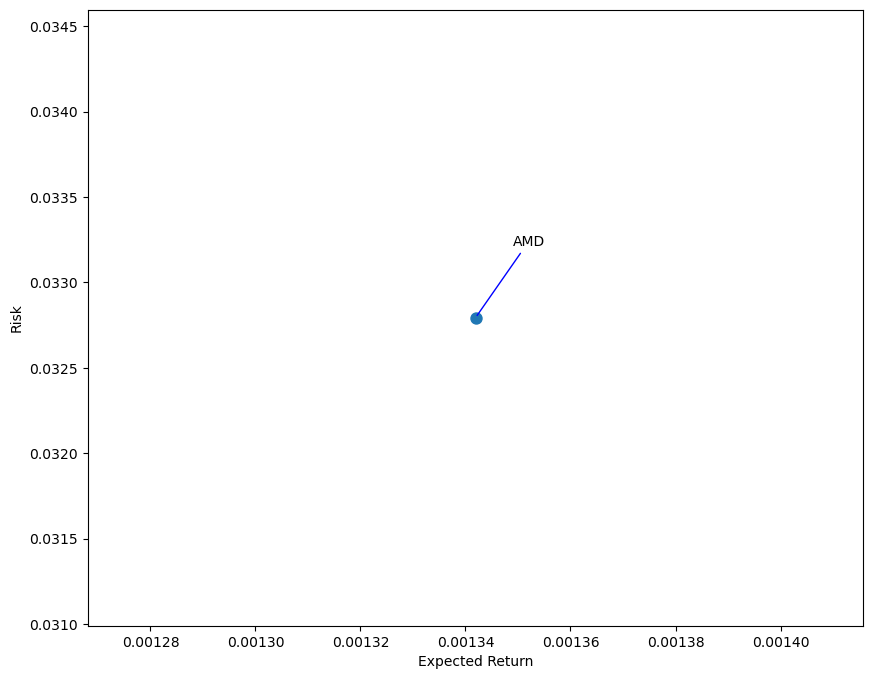

In [25]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10,8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

plt.annotate(stock, xy=(rets.mean(), rets.std()), xytext=(50,50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue'))

## Prediction Model